In [1]:
import numpy as np 
import pandas as pd 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plotter
import os
import matplotlib.pyplot as plt

import spacy
import string
!python -m spacy download en_core_web_lg
import en_core_web_lg
from scipy.sparse import hstack

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.model_selection import KFold
from scipy import stats
from scipy.stats import norm, skew 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer
import optuna
import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline

#!python -m spacy download en_core_web_md
#!python -m spacy download en_core_web_trf
#import en_core_web_sm
#import en_core_web_md
#import en_core_web_trf
import warnings
warnings.filterwarnings('ignore')


     -------------------------------------- 587.7/587.7 MB 3.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
df=pd.read_csv("Restaurant_Reviews.tsv",sep="\t")


In [4]:
df

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [5]:
train_df, test_df = train_test_split(df,test_size=0.2)


In [6]:
train_df=train_df.reset_index(drop=True)
test_df=test_df.reset_index(drop=True)

In [7]:
train_df

,Review,Liked
0,"He was extremely rude and really, there are so...",0
1,I had to wait over 30 minutes to get my drink ...,0
2,So good I am going to have to review this plac...,1
3,Join the club and get awesome offers via email.,1
4,"Great Subway, in fact it's so good when you co...",1
...,...,...
795,I had about two bites and refused to eat anymore.,0
796,All I have to say is the food was amazing!!!,1
797,I paid the bill but did not tip because I felt...,0
798,No one at the table thought the food was above...,0


In [8]:
test_df

,Review,Liked
0,I'll definitely be in soon again.,1
1,Wow very spicy but delicious.,1
2,It's NOT hard to make a decent hamburger.,0
3,"Point your finger at any item on the menu, ord...",1
4,Waitress was good though!,1
...,...,...
195,OMG I felt like I had never eaten Thai food un...,1
196,"i felt insulted and disrespected, how could yo...",0
197,Kind of hard to mess up a steak but they did.,0
198,Gave up trying to eat any of the crust (teeth ...,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  800 non-null    object
 1   Liked   800 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  200 non-null    object
 1   Liked   200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [11]:
train_df.isnull().sum()

Review    0
Liked     0
dtype: int64

In [12]:
test_df.isnull().sum()

Review    0
Liked     0
dtype: int64

In [13]:
train_df=train_df.rename(columns={"Review": "text", "Liked": "label"})


In [14]:
train_df

,text,label
0,"He was extremely rude and really, there are so...",0
1,I had to wait over 30 minutes to get my drink ...,0
2,So good I am going to have to review this plac...,1
3,Join the club and get awesome offers via email.,1
4,"Great Subway, in fact it's so good when you co...",1
...,...,...
795,I had about two bites and refused to eat anymore.,0
796,All I have to say is the food was amazing!!!,1
797,I paid the bill but did not tip because I felt...,0
798,No one at the table thought the food was above...,0


In [15]:
test_df=test_df.rename(columns={"Review": "text", "Liked": "label"})

In [16]:
test_df

,text,label
0,I'll definitely be in soon again.,1
1,Wow very spicy but delicious.,1
2,It's NOT hard to make a decent hamburger.,0
3,"Point your finger at any item on the menu, ord...",1
4,Waitress was good though!,1
...,...,...
195,OMG I felt like I had never eaten Thai food un...,1
196,"i felt insulted and disrespected, how could yo...",0
197,Kind of hard to mess up a steak but they did.,0
198,Gave up trying to eat any of the crust (teeth ...,0


In [17]:
train_df.head()


,text,label
0,"He was extremely rude and really, there are so...",0
1,I had to wait over 30 minutes to get my drink ...,0
2,So good I am going to have to review this plac...,1
3,Join the club and get awesome offers via email.,1
4,"Great Subway, in fact it's so good when you co...",1


In [18]:
test_df.head()

,text,label
0,I'll definitely be in soon again.,1
1,Wow very spicy but delicious.,1
2,It's NOT hard to make a decent hamburger.,0
3,"Point your finger at any item on the menu, ord...",1
4,Waitress was good though!,1


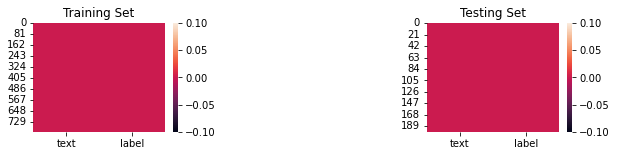

In [21]:
plt.figure(figsize = (10, 2))

plt.subplot(1, 3, 1)
plt.title("Training Set")
sns.heatmap(train_df.isnull())

plt.subplot(1, 3, 3)
plt.title("Testing Set")
sns.heatmap(test_df.isnull())
plt.show()

In [26]:
label_df=train_df['label'].value_counts().index

In [27]:
val_df=train_df['label'].value_counts().values

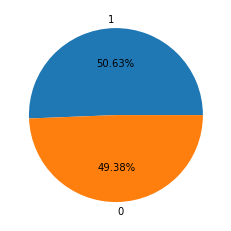

In [30]:
plt.pie(x=val_df,labels=label_df,autopct="%1.2f%%")
plt.show()

<AxesSubplot:xlabel='label', ylabel='count'>

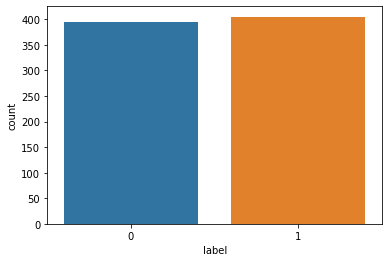

In [34]:
sns.countplot(train_df['label'])

In [31]:
label_df=test_df['label'].value_counts().index

In [32]:
val_df=test_df['label'].value_counts().values

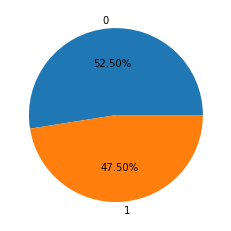

In [33]:
plt.pie(x=val_df,labels=label_df,autopct="%1.2f%%")
plt.show()

<AxesSubplot:xlabel='label', ylabel='count'>

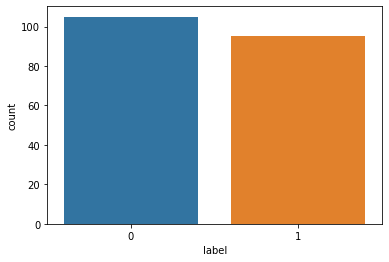

In [35]:
sns.countplot(test_df['label'])

# Preprocessing

In [36]:
nlp = spacy.load("en_core_web_lg")
stop_words = nlp.Defaults.stop_words
punctuations = string.punctuation

In [37]:
def spacy_tokenizer(sentence):
    if type(sentence) == float:
        sentence=sentence
    else:
        doc = nlp(sentence)
        mytokens = [ word.lemma_.lower().strip() for word in doc ]
        mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
        sentence = " ".join(mytokens)
    return sentence


In [39]:
train_df['tokenized_Text'] = train_df['text'].apply(spacy_tokenizer)


In [40]:
train_df

,text,label,tokenized_Text
0,"He was extremely rude and really, there are so...",0,extremely rude restaurant love dine weekend vegas
1,I had to wait over 30 minutes to get my drink ...,0,wait 30 minute drink long 2 arepas
2,So good I am going to have to review this plac...,1,good review place twice herea tribute place tr...
3,Join the club and get awesome offers via email.,1,join club awesome offer email
4,"Great Subway, in fact it's so good when you co...",1,great subway fact good come subway meet expect...
...,...,...,...
795,I had about two bites and refused to eat anymore.,0,bite refuse eat anymore
796,All I have to say is the food was amazing!!!,1,food amazing
797,I paid the bill but did not tip because I felt...,0,pay bill tip feel server terrible job
798,No one at the table thought the food was above...,0,table think food average worth wait


In [42]:
X = train_df.iloc[:,2]
y = train_df.iloc[:,1]

In [43]:
X

0      extremely rude restaurant love dine weekend vegas
1                     wait 30 minute drink long 2 arepas
2      good review place twice herea tribute place tr...
3                          join club awesome offer email
4      great subway fact good come subway meet expect...
                             ...                        
795                              bite refuse eat anymore
796                                         food amazing
797                pay bill tip feel server terrible job
798                  table think food average worth wait
799    far sushi connoisseur definitely tell differen...
Name: tokenized_Text, Length: 800, dtype: object

In [44]:
y

0      0
1      0
2      1
3      1
4      1
      ..
795    0
796    1
797    0
798    0
799    0
Name: label, Length: 800, dtype: int64

# Convert a collection of text documents to a matrix of token counts.

In [45]:
vec = CountVectorizer()
X_vec = vec.fit_transform(X)



In [46]:
X_train, X_eval, y_train, y_eval = train_test_split(X_vec,y,test_size=0.2,stratify=y)



# Voting Modeling

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier,RidgeClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
clf1 = SGDClassifier()
clf2 = XGBClassifier()
clf3 = KNeighborsClassifier()
clf4 = LogisticRegression()
clf5=  RidgeClassifier()
clf6= DummyClassifier()
clf7= SVC()
clf8=RandomForestClassifier()


In [52]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('SGD', clf1), ('XGB', clf2), ('KN', clf3),('LG', clf4),
                                    ('RC', clf5), ('DC', clf6),('SVC', clf7),('RFC',clf8)],voting='hard')

for clf, label in zip([clf1,clf2,clf3,clf4,clf5,clf6,clf7,clf8,eclf], 
                      ['SGD','XGB','KN','LG','DC','SVC','RFC','Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.75 (+/- 0.03) [SGD]
Accuracy: 0.72 (+/- 0.04) [XGB]
Accuracy: 0.56 (+/- 0.02) [KN]
Accuracy: 0.78 (+/- 0.02) [LG]
Accuracy: 0.76 (+/- 0.02) [DC]
Accuracy: 0.51 (+/- 0.00) [SVC]
Accuracy: 0.75 (+/- 0.01) [RFC]
Accuracy: 0.73 (+/- 0.02) [Ensemble]


In [53]:
clf1 = SGDClassifier()
clf2 = XGBClassifier()
clf3 = LogisticRegression()
clf4=  RidgeClassifier()
clf5= DummyClassifier()

In [54]:
eclf = VotingClassifier(estimators=[('SGD', clf1), ('XGB', clf2),('LG', clf3),
                                    ('RC', clf5),('SVC', clf5)],voting='hard')

# Training

In [55]:
Voting_model=eclf.fit(X_train, y_train)


In [56]:
y_pred_Voting = Voting_model.predict(X_eval)


Voting accuracy is: 75.000%


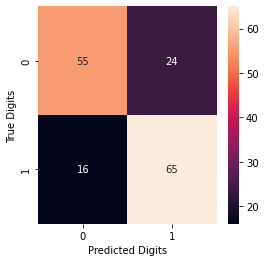

In [57]:
Voting_acc = accuracy_score(y_eval, y_pred_Voting)
print("Voting accuracy is: {0:.3f}%".format(Voting_acc * 100))
cm = confusion_matrix(y_eval, y_pred_Voting)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted Digits")
plt.ylabel("True Digits")
plt.show()

# Predict Test Data

In [58]:
test_df['tokenized_Text'] = test_df['text'].apply(spacy_tokenizer)
test_df


,text,label,tokenized_Text
0,I'll definitely be in soon again.,1,definitely soon
1,Wow very spicy but delicious.,1,wow spicy delicious
2,It's NOT hard to make a decent hamburger.,0,hard decent hamburger
3,"Point your finger at any item on the menu, ord...",1,point finger item menu order disappoint
4,Waitress was good though!,1,waitress good
...,...,...,...
195,OMG I felt like I had never eaten Thai food un...,1,omg feel like eat thai food dish
196,"i felt insulted and disrespected, how could yo...",0,feel insult disrespect talk judge human like
197,Kind of hard to mess up a steak but they did.,0,kind hard mess steak
198,Gave up trying to eat any of the crust (teeth ...,0,try eat crust tooth sore


In [59]:
X_test = test_df.iloc[:,2]
y_test = test_df.iloc[:,1]

In [60]:
test_vec = vec.transform(X_test)
test_vec

<200x1360 sparse matrix of type '<class 'numpy.int64'>'
	with 687 stored elements in Compressed Sparse Row format>

In [61]:
y_pred_test_Voting = Voting_model.predict(test_vec)
y_pred_test_Voting

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1], dtype=int64)

Voting accuracy is: 74.000%


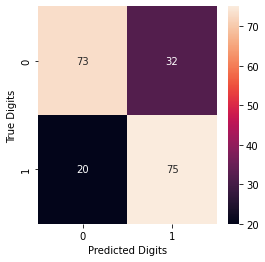

In [62]:
Voting_test_acc = accuracy_score(y_test, y_pred_test_Voting)
print("Voting accuracy is: {0:.3f}%".format(Voting_test_acc * 100))
cm = confusion_matrix(y_test, y_pred_test_Voting)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted Digits")
plt.ylabel("True Digits")
plt.show()